COVID Excess Savings by Holder

Census CEX annual data for 2019: https://www.bls.gov/cex/2019/combined/quintile.pdf

OI data: https://github.com/OpportunityInsights/EconomicTracker/tree/main/data

In [2]:
import pandas as pd
import numpy as np

In [41]:
# Copy over some values from CEX 2019 table
d = {'income': {}, 'exp': {}, 'n': {}, 'size': {}, 'earners': {}}

d['income']['q1'] = 12236
d['income']['q2'] = 32945
d['income']['q3'] = 53123
d['income']['q4'] = 83864
d['income']['q5'] = 174777

d['exp']['q1'] = 28672
d['exp']['q2'] = 40472
d['exp']['q3'] = 53045
d['exp']['q4'] = 71173
d['exp']['q5'] = 121571

d['n']['q1'] = 26367
d['n']['q2'] = 26387
d['n']['q3'] = 26578
d['n']['q4'] = 26375
d['n']['q5'] = 26536

d['size']['q1'] = 1.6
d['size']['q2'] = 2.2
d['size']['q3'] = 2.5
d['size']['q4'] = 2.8
d['size']['q5'] = 3.2

d['earners']['q1'] = 0.4
d['earners']['q2'] = 0.9
d['earners']['q3'] = 1.3
d['earners']['q4'] = 1.8
d['earners']['q5'] = 2.1

In [42]:
quintiles = ['q1', 'q2', 'q3', 'q4', 'q5']

# Aggregate income by quintile
d['agg_inc'] = {}
for q in quintiles:
    d['agg_inc'][q] = d['income'][q] * d['n'][q]
    
# Mean savings by quintile
d['save'] = {}
for q in quintiles:
    d['save'][q] = d['income'][q] - d['exp'][q]
    
# Aggregate saving by quintile
d['agg_save'] = {}
for q in quintiles:
    d['agg_save'][q] = d['save'][q] * d['n'][q]

In [244]:
total_income = sum(d['agg_inc'][q] for q in quintiles)
print('Total after tax income, in USD trillion', f'{total_income / 1_000_000_000:.2f}')
total_save = sum(d['agg_save'][q] for q in quintiles)
print('Total savings, in USD trillion', f'{total_save / 1_000_000_000:.2f}')

Total after tax income, in USD trillion 9.45
Total savings, in USD trillion 1.12


In [54]:
series = 'PMSAVE'
url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
df = pd.read_csv(url, index_col='DATE', parse_dates=True)
val2019 = df.loc['2019-12-01', 'VALUE']
print('Total savings, in USD trillion (Dec 2019)', f'{val2019 / 1000: .2f}')

Total savings, in USD trillion (Dec 2019)  1.19


Excess savings

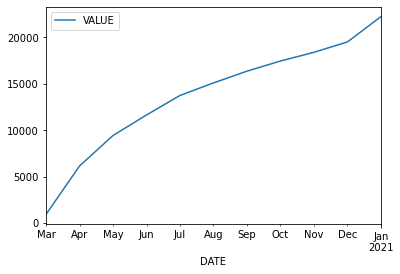

In [61]:
excess_saving = (df.loc['2020-03-01':] - 1200).cumsum()
excess_saving.plot();

OI data

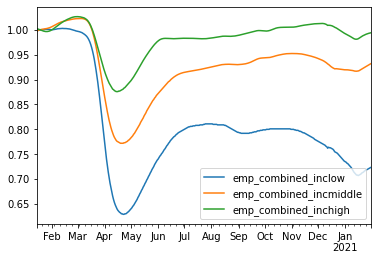

In [121]:
emp_full = pd.read_csv('Employment Combined - National - Daily.csv')
emp_full.index = pd.to_datetime(emp_full[['year', 'month', 'day']])
emp = emp_full[['emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh']] + 1
emp.plot();

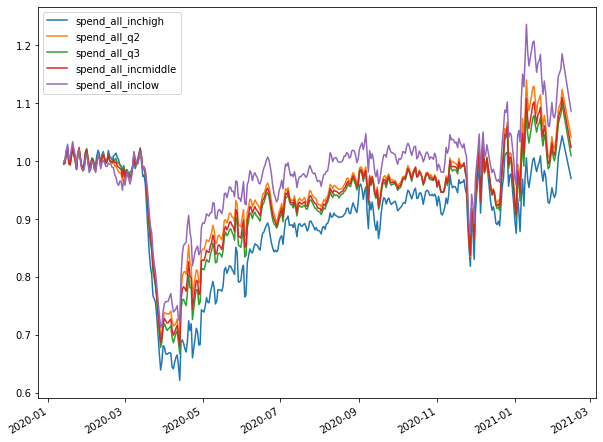

In [120]:
exp_full = pd.read_csv('Affinity - National - Daily.csv')
exp_full.index = pd.to_datetime(exp_full[['year', 'month', 'day']])
exp = exp_full.loc['2020-01-13':, ['spend_all_inchigh', 'spend_all_q2', 'spend_all_q3', 
                'spend_all_incmiddle', 'spend_all_inclow']].astype(float) + 1
exp.plot(figsize=(10, 8));

In [225]:
# Map quintiles to employment groups
q_to_emp = {'q1': 'emp_combined_inclow',
            'q2': 'emp_combined_inclow',
            'q3': 'emp_combined_incmiddle',
            'q4': 'emp_combined_inchigh',
            'q5': 'emp_combined_inchigh'}

# Map quintiles to expenditure groups
q_to_exp = {'q1': 'spend_all_inclow',
            'q2': 'spend_all_q2',
            'q3': 'spend_all_incmiddle',
            'q4': 'spend_all_q3',
            'q5': 'spend_all_inchigh'}

# High income households don't get stimulus
q_to_stim = {'q1': 1, 'q2': 1, 'q3': 0.8, 'q4': 0, 'q5': 0}

March excess savings by holder

In [245]:
date = '2020-03-15'
date_fred = '2020-03-01'
month = 'March'
stim = 1200 * 12 #(Basically just making this part up)
ui = ((600 + 250) * 52)
results = {'ui': {}, 'stim': {}, 'inc': {}, 'exp': {}, 'save': {}, 'agg_save': {}}

for q in quintiles:
    results['ui'][q] = (1 - emp.loc[date, q_to_emp[q]]) * ui
    results['stim'][q] = ((stim * q_to_stim[q]) * d['size']['q1'])
    results['inc'][q] = (d['income'][q] * emp.loc[date, q_to_emp[q]]) + results['ui'][q] + results['stim'][q]
    results['exp'][q] = d['exp'][q] * exp.loc[date, q_to_exp[q]]
    results['save'][q] = results['inc'][q] - results['exp'][q]
    results['agg_save'][q] = results['save'][q] * d['n'][q]
    
    
agg_save = sum(results['agg_save'][q] for q in quintiles)    
print(f'Est. aggregate savings, {month}', f'{agg_save / 1_000_000_000:.2f}')
print(f'Actual aggregate savings, {month}', df.loc[date_fred, 'VALUE'] / 1000)

print('')

for q in quintiles:
    share_agg_save = (results['agg_save'][q] / agg_save) * 100
    print(f'Share of aggregate savings, {q}', f'{share_agg_save:.1f}')

Est. aggregate savings, March 2.88
Actual aggregate savings, March 2.1307

Share of aggregate savings, q1 7.2
Share of aggregate savings, q2 14.9
Share of aggregate savings, q3 11.5
Share of aggregate savings, q4 13.0
Share of aggregate savings, q5 53.4


April excess savings by holder, needs to be switched to cumulative

In [258]:
date = '2020-04-15'
date_fred = '2020-04-01'
month = 'April'
stim = 800 * 12 #(Basically just making this part up)
ui = ((600 + 250) * 52)
results = {'ui': {}, 'stim': {}, 'inc': {}, 'exp': {}, 'save': {}, 'agg_save': {}}

for q in quintiles:
    results['ui'][q] = (1 - emp.loc[date, q_to_emp[q]]) * ui
    results['stim'][q] = ((stim * q_to_stim[q]) * d['size']['q1'])
    results['inc'][q] = (d['income'][q] * emp.loc[date, q_to_emp[q]]) + results['ui'][q] + results['stim'][q]
    results['exp'][q] = d['exp'][q] * exp.loc[date, q_to_exp[q]]
    results['save'][q] = results['inc'][q] - results['exp'][q]
    results['agg_save'][q] = results['save'][q] * d['n'][q]
    
    
agg_save = sum(results['agg_save'][q] for q in quintiles)    
print(f'Est. aggregate savings, {month}', f'{agg_save / 1_000_000_000:.2f}')
print(f'Actual aggregate savings, {month}', df.loc[date_fred, 'VALUE'] / 1000)

print('')

for q in quintiles:
    share_agg_save = (results['agg_save'][q] / agg_save) * 100
    print(f'Share of aggregate savings, {q}', f'{share_agg_save:.1f}')

Est. aggregate savings, April 4.02
Actual aggregate savings, April 6.4136999999999995

Share of aggregate savings, q1 9.9
Share of aggregate savings, q2 13.1
Share of aggregate savings, q3 11.6
Share of aggregate savings, q4 16.3
Share of aggregate savings, q5 49.2


May excess savings by holder (needs to be switched to cumulative)

In [259]:
date = '2020-05-15'
date_fred = '2020-05-01'
month = 'May'
stim = 100 * 12 #(Basically just making this part up)
ui = ((600 + 250) * 52)
results = {'ui': {}, 'stim': {}, 'inc': {}, 'exp': {}, 'save': {}, 'agg_save': {}}

for q in quintiles:
    results['ui'][q] = (1 - emp.loc[date, q_to_emp[q]]) * ui
    results['stim'][q] = ((stim * q_to_stim[q]) * d['size']['q1'])
    results['inc'][q] = (d['income'][q] * emp.loc[date, q_to_emp[q]]) + results['ui'][q] + results['stim'][q]
    results['exp'][q] = d['exp'][q] * exp.loc[date, q_to_exp[q]]
    results['save'][q] = results['inc'][q] - results['exp'][q]
    results['agg_save'][q] = results['save'][q] * d['n'][q]
    
    
agg_save = sum(results['agg_save'][q] for q in quintiles)    
print(f'Est. aggregate savings, {month}', f'{agg_save / 1_000_000_000:.2f}')
print(f'Actual aggregate savings, {month}', df.loc[date_fred, 'VALUE'] / 1000)

print('')

for q in quintiles:
    share_agg_save = (results['agg_save'][q] / agg_save) * 100
    print(f'Share of aggregate savings, {q}', f'{share_agg_save:.1f}')

Est. aggregate savings, May 2.72
Actual aggregate savings, May 4.4891000000000005

Share of aggregate savings, q1 -1.9
Share of aggregate savings, q2 3.2
Share of aggregate savings, q3 7.2
Share of aggregate savings, q4 21.0
Share of aggregate savings, q5 70.4


In [263]:
date = '2020-06-15'
date_fred = '2020-06-01'
month = 'June'
stim = 0 * 12 #(Basically just making this part up)
ui = ((600 + 250) * 52)
results = {'ui': {}, 'stim': {}, 'inc': {}, 'exp': {}, 'save': {}, 'agg_save': {}}

for q in quintiles:
    results['ui'][q] = (1 - emp.loc[date, q_to_emp[q]]) * ui
    results['stim'][q] = ((stim * q_to_stim[q]) * d['size']['q1'])
    results['inc'][q] = (d['income'][q] * emp.loc[date, q_to_emp[q]]) + results['ui'][q] + results['stim'][q]
    results['exp'][q] = d['exp'][q] * exp.loc[date, q_to_exp[q]]
    results['save'][q] = results['inc'][q] - results['exp'][q]
    results['agg_save'][q] = results['save'][q] * d['n'][q]
    
    
agg_save = sum(results['agg_save'][q] for q in quintiles)    
print(f'Est. aggregate savings, {month}', f'{agg_save / 1_000_000_000:.2f}')
print(f'Actual aggregate savings, {month}', df.loc[date_fred, 'VALUE'] / 1000)

print('')

for q in quintiles:
    share_agg_save = (results['agg_save'][q] / agg_save) * 100
    print(f'Share of aggregate savings, {q}', f'{share_agg_save:.1f}')

Est. aggregate savings, June 2.21
Actual aggregate savings, June 3.4097

Share of aggregate savings, q1 -9.7
Share of aggregate savings, q2 -1.9
Share of aggregate savings, q3 5.0
Share of aggregate savings, q4 23.1
Share of aggregate savings, q5 83.5
